

# Feature Importance for Biological Aging (FIBA) code example

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
from sklearn import preprocessing
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn import metrics
import json
from scipy.stats import zscore
import pickle
from concurrent.futures import ProcessPoolExecutor
import statsmodels.api as sm
import multiprocessing as mp
import time
import random
import os

%matplotlib inline


# Load data

In [2]:
# protein mdata
prot_md = pd.read_csv("../plasma_proteome_Benoit_data/Covance/Covance_5k_prot_md_clean_with_homo_with_gtex_with_fc.csv")


In [3]:
#500 bootstrap model seeds
with open('../data/dictionaries/Bootstrap_and_permutation_500_seed_dict.json') as fp:
    seed_dict_final = json.load(fp)
    
bs_seed_list = seed_dict_final["BS_Seed"]
print(len(bs_seed_list))


500


In [4]:
# organ:proteinlist dictionary
with open('../data/dictionaries/tissue_pproteinlist_5k_dict_gtex_tissue_enriched_fc4_stable_assay_proteins_seqid_organage.json') as fp:
    tissue_plist_dict_enr_stable_assay_seqid = json.load(fp)

tissue_plist_dict_enr_stable_assay = {k:[dict(zip(prot_md.SeqId, prot_md.Somamer))[vsub] for vsub in v] for k,v in tissue_plist_dict_enr_stable_assay_seqid.items()}
tissue_plist_dict_enr_stable_assay["Adipose"]


['FABP4.15386.7.3',
 'LEP.8484.24.3',
 'ADIPOQ.3554.24.1',
 'TNMD.6578.29.3',
 'ITLN1.18830.1.3']

In [5]:
#for multiprocessing
import mkl
mkl.set_num_threads(1)


2

In [6]:
#All datasets integrated
df = pd.read_csv("../plasma_proteome_Benoit_data/All_datasets_Covance_LonGenity_SADRC_WUADRC_mean_replicates.csv").set_index("Barcode")
df = df.loc[df.Cohort2=="KADRC"]
kadrcids = list(df.index)

#metadata
md = df.iloc[:,:11]
md_hot = pd.get_dummies(md)
md_hot = md_hot[["Age","Sex_F","Diagnosis_group_HC"]]
md_hot.index=list(range(len(md_hot)))
md_hot.index.name="Barcode"
md_hot


/local/scratch/hoh3/slrmtmp.41894087/ipykernel_38295/3684220579.py:2: DtypeWarning: Columns (0,6,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../plasma_proteome_Benoit_data/All_datasets_Covance_LonGenity_SADRC_WUADRC_mean_replicates.csv").set_index("Barcode")


,Age,Sex_F,Diagnosis_group_HC
Barcode,,,
0,80.0,1,0
1,70.0,1,1
2,78.0,1,0
3,66.0,0,0
4,82.0,1,1
...,...,...,...
3070,74.0,1,1
3071,55.0,0,0
3072,65.0,1,1


In [7]:
#protein level
df_prot = df[tissue_plist_dict_enr_stable_assay["Conventional"]]
df_prot.index=md_hot.index
df_prot


,CRYBB2.10000.28.3,RAF1.10001.7.3,ZNF41.10003.15.3,ELK1.10006.25.3,GUCA1A.10008.43.3,OCRL.10011.65.3,SPDEF.10012.5.3,SNAI2.10014.31.3,KCNAB2.10015.119.3,POLH.10022.207.3,...,KIAA1467.9981.18.3,PRSS35.9983.97.3,YIPF6.9984.12.3,NPW.9986.14.3,LRRC24.9989.12.3,ZNF264.9993.11.3,ATP4B.9994.217.3,DUT.9995.6.3,UBXN4.9997.12.3,IRF6.9999.1.3
Barcode,,,,,,,,,,,,,,,,,,,,,
0,2.731991,2.436640,2.310693,2.830332,2.620136,3.485721,3.072360,2.909610,2.780389,2.352954,...,2.716254,2.763802,2.840420,3.539038,2.803730,3.097951,3.211628,3.027594,3.789672,3.121034
1,2.713323,2.411620,2.225568,2.756636,2.746790,3.497013,3.180642,2.912700,2.746245,2.299943,...,2.833530,2.785045,2.814447,3.120936,2.667079,3.018950,3.184890,3.043519,3.670348,2.949731
2,2.712566,2.388989,2.213252,2.758912,2.682416,3.563066,3.278479,2.950316,2.707229,2.197005,...,2.829368,2.789863,2.808818,3.685231,2.620240,3.114878,3.179034,3.185202,3.936695,3.061415
3,2.722058,2.525045,2.221675,2.775028,2.565139,3.410558,3.114944,2.899383,2.832573,2.288920,...,2.675320,2.878234,2.808818,3.558601,2.838849,3.134368,3.185910,3.124732,3.958277,3.286995
4,2.739651,2.402777,2.639984,2.776701,2.754807,3.433498,3.200111,2.952550,2.690639,2.242790,...,2.897132,2.796644,2.849542,4.121067,2.607669,3.081743,3.185910,3.096771,3.733751,3.183583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3070,2.713994,2.402089,2.188084,2.773494,2.886829,3.529918,3.283505,3.009196,2.728191,2.234517,...,2.829882,2.828402,2.844601,3.822057,2.648458,3.074999,3.243807,3.047080,3.817427,3.087959
3071,2.783618,2.491922,2.259355,2.746323,2.826464,3.415858,3.132420,2.958181,2.808684,2.244277,...,2.801747,2.844850,2.785401,3.764878,2.684396,3.186137,3.498531,2.984257,3.590139,2.964307
3072,2.893318,2.416308,2.237041,2.794070,2.675412,3.445651,3.153937,2.975570,2.731750,2.310268,...,2.761025,2.724112,2.828467,3.580936,2.654754,3.063033,3.202298,3.090117,3.714145,3.474158


In [8]:
#trait
clin_df=pd.read_csv("../plasma_proteome_Benoit_data/WUADRC/processed/WashU_Plasma_SomaScan7K_clin.csv").set_index("Barcode")
clin_df=clin_df.rename({"CDRGLOB_at_blood_draw":"CDRGLOB", "CDRSUM_at_blood_draw":"CDRSUM"}, axis=1)
clin_df=clin_df.loc[kadrcids]
clin_df=clin_df[["CDRGLOB","CDRSUM"]]
clin_df.index=md_hot.index
clin_df


,CDRGLOB,CDRSUM
Barcode,,
0,1.0,5.0
1,0.0,0.0
2,0.5,0.5
3,1.0,6.0
4,0.0,0.0
...,...,...
3070,0.0,NaN
3071,NaN,NaN
3072,0.0,0.0


In [9]:
#assume CDR scores increase with age and disease
df_clin_age=pd.DataFrame({"clin":list(clin_df.columns), "Age_Beta":[1]*len(clin_df.columns), "Age_p":[0]*len(clin_df.columns)})
df_clin_age


,clin,Age_Beta,Age_p
0,CDRGLOB,1,0
1,CDRSUM,1,0


# FIBA workflow

Workflow for a single organ aging model:
1. for each bootstrap seed...
2. calculate correlation between model age gap and trait
3. permute values of protein1
4. recalculate correlation between model age gap and trait
5. the difference in correlation after permutation is the FIBA score
6. permute 5 times and take average FIBA score
7. repeat for all proteins in the aging model
8. repeat for all aging models


In [10]:
from sklearn.linear_model import LinearRegression
import time
from sklearn.metrics import mean_squared_error
import random

In [11]:
def Calculate_feature_importance_all_seeds(df_prot, md_hot, allclin_df, df_clin_age, trait, 
                                           tissue_plist_dict, tissue, bs_seed_list, train_cohort,
                                           agerange, norm, performance_CUTOFF=0.95,
                                           numperm=5, random_seed=0, NPOOL=10,
                                           pfirst=False, plast=False):
    
     # setup
    clin_df = allclin_df[[trait]].dropna().copy()        
    df_tissue = df_prot.loc[clin_df.index][tissue_plist_dict[tissue]]
    cwa = int(df_clin_age.loc[df_clin_age.clin==trait].Age_Beta)  
    
    pool=mp.Pool(NPOOL)    
    input_list=[(df_tissue, md_hot.loc[clin_df.index], train_cohort,
                 clin_df, 
                 md_hot[["Sex_F"]].merge(df_tissue, on="Barcode"), #df_X for age prediction
                 clin_df.merge(md_hot[["Age", "Sex_F"]], on="Barcode").apply(stats.zscore), #df_X for trait beta association
                 trait, cwa, tissue,
                 agerange, norm, performance_CUTOFF,
                 numperm, random_seed, seed, pfirst, plast) for seed in bs_seed_list]
    output_list = pool.starmap(Calculate_feature_importance_one_seed, input_list)  #list of lists of lists
    pool.close()
    pool.join()
    
    df_results_all_seeds = pd.concat(output_list, join="outer")
    return df_results_all_seeds


def Calculate_feature_importance_one_seed(df_tissue, md_hot, train_cohort,
                                          clin_df, 
                                          df_X,
                                          df_X_trait_beta, 
                                          trait, cwa, tissue,
                                          agerange, norm, performance_CUTOFF,
                                          numperm, random_seed, seed, 
                                          pfirst, plast):

    #load model
    modelfp = "../data/ml_models/"+train_cohort+"/"+agerange+"/"+norm+"/"+tissue+"/"+train_cohort+"_"+agerange+"_"+norm+"_lasso_"+tissue+"_seed"+str(seed)+"_aging_model.pkl"
    model = pickle.load(open(modelfp, 'rb'))
    coef_dict = dict(zip(df_tissue.columns, list(model.coef_)[1:]))    

    #calculate baseline age and trait correlation
    df_Y = Predict_age_with_model(df_X, md_hot, tissue, model, seed)

    orig_r,p = stats.pearsonr(df_Y.loc[df_Y.Diagnosis_group_HC==1].Age, 
                              df_Y.loc[df_Y.Diagnosis_group_HC==1].Pred_Age)    
    orig_beta = Calculate_trait_beta(df_X_trait_beta, df_Y, trait)
    
    #to store
    results = []
    first=0
    last=len(df_tissue.columns)
    if plast:
        first=pfirst
        last=plast
    
    # for each protein, permute n times, and recalculate
    for feature in df_tissue.columns[first:last]:
        if coef_dict[feature]!=0:   #unless protein has no weight in model
            #print(feature)
            df_X_perm = df_X.copy()
            perm_r_list = []
            perm_beta_list = []
            fib_list = []
            fic_list = []
            for i in range(numperm):

                #permute feature, repredict age, recalculate r and trait beta
                df_X_perm[feature] = np.random.RandomState(seed=random_seed).permutation(df_X_perm[feature])
               # print(df_X_perm[feature])
                
                df_Y_perm = Predict_age_with_model(df_X_perm, md_hot, tissue, model, seed)
                #perm_r,p = stats.pearsonr(df_Y_perm.Age, df_Y_perm.Pred_Age)
                perm_r,p = stats.pearsonr(df_Y_perm.loc[df_Y_perm.Diagnosis_group_HC==1].Age, 
                                          df_Y_perm.loc[df_Y_perm.Diagnosis_group_HC==1].Pred_Age) 
                perm_beta = Calculate_trait_beta(df_X_trait_beta, df_Y_perm, trait)

                perm_r_list.append(perm_r)
                perm_beta_list.append(perm_beta)

            #take average r,trait_beta from n permutations
            mean_perm_r = np.mean(perm_r_list)
            mean_perm_beta = np.mean(perm_beta_list)        

            #calculate feature importance
            fi_chrono = orig_r - mean_perm_r
            fi_bio = Calculate_feat_imp_bio(orig_beta, mean_perm_beta, cwa)
            #print(feature, fi_chrono, fi_bio)
            results.append([trait, feature, seed, 
                            orig_beta, mean_perm_beta, fi_bio,
                            orig_r, mean_perm_r, fi_chrono])

        else:    #if protein has no weight in model, don't save info
            results.append([trait, feature, seed, 
                            float("nan"), float("nan"), float("nan"),
                            float("nan"), float("nan"), float("nan")])
    df_results = pd.DataFrame(results, 
                              columns=["trait", "feature_perm", "BS_Seed",
                                       "orig_trait_beta", "mean_perm_beta", "fi_bio",
                                       "orig_r", "mean_perm_r", "fi_chrono"])
    df_results["tissue"]=tissue
    return df_results



def Predict_age_with_model(df_X, md_hot, tissue, model, seed):
    pred_Y = model.predict(df_X.to_numpy())
    df_Y = md_hot.copy()
    df_Y["Pred_Age"]=pred_Y
    df_Y["yhat"] = Add_yhat(df_Y)
    df_Y["dage_resid"] = df_Y["Pred_Age"] - df_Y["yhat"]
    df_Y["dage_resid_zscored"] = stats.zscore(df_Y["dage_resid"])   
    return df_Y

def Add_yhat(df):
    lm = LinearRegression()
    X = np.array(df.Age).reshape(-1,1)
    Y = np.array(df.Pred_Age)
    lm.fit(X, Y)
    yhat = lm.predict(X)
    return yhat
            
def Calculate_trait_beta(X_df_z, Y_df, trait):      # ∆age ~ trait + age + sex
    X = sm.add_constant(X_df_z) 
    Y = list(Y_df.dage_resid_zscored)
    model = sm.OLS(Y,X)
    res = model.fit()
    trait_beta = res.params[trait]
    return trait_beta 

def Calculate_feat_imp_bio(orig_beta, perm_beta, cwa):
    if cwa<0:
        feat_imp_bio = perm_beta - orig_beta
    else:
        feat_imp_bio = orig_beta - perm_beta
    return feat_imp_bio
    

In [12]:
#example with brain aging model, CDRGLOB as the trait, and 2/500 bootstraps
res = Calculate_feature_importance_all_seeds(df_prot, md_hot, clin_df, df_clin_age, "CDRGLOB", 
                                           tissue_plist_dict_enr_stable_assay, "Brain", bs_seed_list[:2], train_cohort="KADRC",
                                           agerange="HC", norm="Zprot_stableassayps_perf95", numperm=5, random_seed=0, NPOOL=2,
                                           pfirst=False, plast=False)


In [13]:
res

,trait,feature_perm,BS_Seed,orig_trait_beta,mean_perm_beta,fi_bio,orig_r,mean_perm_r,fi_chrono,tissue
0,CDRGLOB,CNTN1.2974.61.2,14338,0.104147,0.106181,-0.002034,0.663857,0.662269,0.001588,Brain
1,CDRGLOB,MEGF10.11168.3.3,14338,0.104147,0.104775,-0.000628,0.663857,0.662324,0.001532,Brain
2,CDRGLOB,HS3ST5.10731.10.3,14338,0.104147,0.115184,-0.011037,0.663857,0.657560,0.006297,Brain
3,CDRGLOB,NGFR.8374.5.3,14338,0.104147,0.102676,0.001471,0.663857,0.662958,0.000898,Brain
4,CDRGLOB,TTC9B.9386.42.3,14338,NaN,NaN,NaN,NaN,NaN,NaN,Brain
...,...,...,...,...,...,...,...,...,...,...
197,CDRGLOB,STMN4.6267.51.3,8195,NaN,NaN,NaN,NaN,NaN,NaN,Brain
198,CDRGLOB,BIRC7.15412.40.3,8195,NaN,NaN,NaN,NaN,NaN,NaN,Brain
199,CDRGLOB,IGLON5.6478.2.3,8195,0.112631,0.109657,0.002973,0.674997,0.613249,0.061748,Brain
200,CDRGLOB,GRIA4.10760.107.3,8195,NaN,NaN,NaN,NaN,NaN,NaN,Brain


In [14]:
def Plot_FIBA(res):
    #plot
    tissue=list(set(res.tissue))[0]
    trait=list(set(res.trait))[0]
    fig,ax=plt.subplots(figsize=(4,4))
    toplot=res.groupby("feature_perm").mean().reset_index()
    plt.scatter(data=toplot, x="fi_chrono", y="fi_bio")

    df_label=toplot.loc[(toplot.fi_chrono>0.02) | (toplot.fi_bio>0.008) | (toplot.fi_bio<-0.02)]
    for k,row in df_label.iterrows():
        plt.text(x=row["fi_chrono"], y=row["fi_bio"], s=row["feature_perm"])
    plt.title(tissue+", "+trait+" Feature Importance")
    plt.axhline(0)
    plt.axvline(0)
    plt.legend().remove()
    plt.show()
    

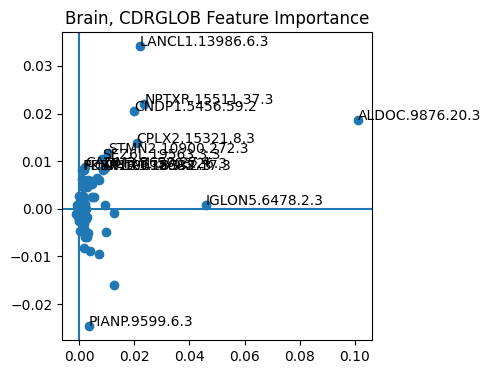

In [15]:
Plot_FIBA(res)
